In [25]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math

class Agent:

    def __init__(self):
        self.money = 0
        self.class_type = 'middle'

    def consume(self, seller, amount):
          self.money -= amount
          seller.money += amount

In [26]:
class Simulation:
    def __init__(self, num_agents, num_time_steps):
        self.num_agents = num_agents
        self.num_time_steps = num_time_steps
        self.agents = [Agent() for _ in range(num_agents)]
        self.total_tax = 0
        self.update_thresholds()
        self.update_wealth()
        self.segregate_agents()
        self.trade_probs = [[0] * self.num_agents for _ in range(self.num_agents)]
        self.initialize_trade_probabilities()

        # Lists to track wealth and class of specific agents
        self.rich_agent_wealth = []
        self.middle_agent_wealth = []
        self.poor_agent_wealth = []
        self.rich_agent_classes = []
        self.middle_agent_classes = []
        self.poor_agent_classes = []

    def update_wealth(self):
        # Generate random wealth values based on specified percentages
        wealth_values = [random.uniform(0.1, 3) for _ in range(int(0.5 * self.num_agents))] + [random.uniform(3, 12) for _ in range(int(0.4 * self.num_agents))] + [random.uniform(12, 50) for _ in range(int(0.1 * self.num_agents))]
        random.shuffle(wealth_values)

        # Update agent wealth values
        for i, agent in enumerate(self.agents):
            agent.money = wealth_values[i]


    def calculate_tax(self, wealth):
        scaled_slab_1 = 3
        scaled_slab_2 = 6
        scaled_slab_3 = 9
        scaled_slab_4 = 12
        scaled_slab_5 = 15

        if wealth <= scaled_slab_1:
            return 0
        elif wealth <= scaled_slab_2:
            return 0.05 * (wealth - scaled_slab_1)
        elif wealth <= scaled_slab_3:
            return 0.1 * (wealth - scaled_slab_2) + 0.05 * (scaled_slab_2 - scaled_slab_1)
        elif wealth <= scaled_slab_4:
            return 0.15 * (wealth - scaled_slab_3) + 0.05 * (scaled_slab_2 - scaled_slab_1) + 0.1 * (scaled_slab_3 - scaled_slab_2)
        elif wealth <= scaled_slab_5:
            return 0.2 * (wealth - scaled_slab_4) + 0.05 * (scaled_slab_2 - scaled_slab_1) + 0.1 * (scaled_slab_3 - scaled_slab_2) + 0.15 * (scaled_slab_4 - scaled_slab_3)
        else:
            return 0.3 * (wealth - scaled_slab_5) + 0.05 * (scaled_slab_2 - scaled_slab_1) + 0.1 * (scaled_slab_3 - scaled_slab_2) + 0.15 * (scaled_slab_4 - scaled_slab_3) + 0.2 * (scaled_slab_5 - scaled_slab_4)

    def calculate_trade_prob(self, agent1, agent2):
        wealth_diff = abs(agent1.money - agent2.money)
        return math.exp(-wealth_diff)

    def roulette_wheel_selection(self, probs):
        cumulative_probs = [sum(probs[:i+1]) for i in range(len(probs))]
        r = random.random() * cumulative_probs[-1]
        for i, prob in enumerate(cumulative_probs):
            if r <= prob:
                return i
    def initialize_trade_probabilities(self):
        # Initialize the matrix with trade probabilities for all pairs of agents
        for i in range(self.num_agents):
            for j in range(i + 1, self.num_agents):
                trade_prob = self.calculate_trade_prob(self.agents[i], self.agents[j])
                self.trade_probs[i][j] = trade_prob
                self.trade_probs[j][i] = trade_prob  # Symmetric matrix

    def update_trade_probabilities(self, agent1_index, agent2_index):
        # Update probabilities involving agent1 and agent2 only
        for i in range(self.num_agents):
            if i != agent1_index:
                self.trade_probs[agent1_index][i] = self.calculate_trade_prob(self.agents[agent1_index], self.agents[i])
                self.trade_probs[i][agent1_index] = self.trade_probs[agent1_index][i]  # Symmetric update

            if i != agent2_index:
                self.trade_probs[agent2_index][i] = self.calculate_trade_prob(self.agents[agent2_index], self.agents[i])
                self.trade_probs[i][agent2_index] = self.trade_probs[agent2_index][i]  # Symmetric update


    def update_agents(self):
        # Pick a random agent as the first agent
        agent1_index = random.randint(0, self.num_agents - 1)
        agent1 = self.agents[agent1_index]

        # Get the probabilities for agent1 trading with all other agents
        agent_probs = self.trade_probs[agent1_index]

        # Select the second agent using roulette wheel selection based on the calculated probabilities
        agent2_index = self.roulette_wheel_selection(agent_probs)
        agent2 = self.agents[agent2_index]

        # Perform the trade between agent1 and agent2
        transaction_amount = 0.075 * (agent1.money * agent2.money) / (agent1.money + agent2.money)
        agent1.consume(agent2, transaction_amount)

        # Update the trade probabilities only for agent1 and agent2 after the trade
        self.update_trade_probabilities(agent1_index, agent2_index)


    def deduct_tax(self):
        for agent in self.agents:
            tax = self.calculate_tax(agent.money)
            agent.money -= tax
            self.total_tax += tax

    def redist(self):
        add_val = self.total_tax / self.num_agents
        for agent in self.agents:
            agent.money += add_val
        self.total_tax = 0

    def update_thresholds(self):
        wealths = [agent.money for agent in self.agents]
        sorted_wealths = np.sort(wealths)

        self.lower_threshold = np.percentile(sorted_wealths, 50)  # 50th percentile
        self.upper_threshold = np.percentile(sorted_wealths, 90)  # 90th percentile

    def segregate_agents(self):
        for agent in self.agents:
            if agent.money <= self.lower_threshold:
                agent.class_type = 'poor'
            elif agent.money >= self.upper_threshold:
                agent.class_type = 'rich'
            else:
                agent.class_type = 'middle'

    def select_and_track_agents(self):
        random.shuffle(self.agents)
        for agent in self.agents:
            if agent.class_type == 'rich':
                self.rich_agent = agent
                break

        for agent in self.agents:
            if agent.class_type == 'middle':
                self.middle_agent = agent
                break

        for agent in self.agents:
            if agent.class_type == 'poor':
                self.poor_agent = agent
                break

        self.rich_agent_wealth.append(self.rich_agent.money)
        self.middle_agent_wealth.append(self.middle_agent.money)
        self.poor_agent_wealth.append(self.poor_agent.money)

        self.rich_agent_classes.append(self.rich_agent.class_type)
        self.middle_agent_classes.append(self.middle_agent.class_type)
        self.poor_agent_classes.append(self.poor_agent.class_type)

    def record_agent_classes(self):
        self.rich_agent_classes.append(self.rich_agent.class_type)
        self.middle_agent_classes.append(self.middle_agent.class_type)
        self.poor_agent_classes.append(self.poor_agent.class_type)

    def run_simulation(self):
        for _ in range(self.num_time_steps):
            self.update_agents()
        self.deduct_tax()
        self.redist()


In [27]:
def gini_coefficient(wealths):
    n = len(wealths)
    if n == 0:
        return 0

    # Step 1: Sort the wealth list
    sorted_wealths = np.sort(wealths)

    # Step 2: Calculate the mean absolute difference
    diff_matrix = np.abs(sorted_wealths[:, None] - sorted_wealths)
    mean_abs_diff = np.mean(diff_matrix)

    # Step 3: Compute the mean wealth
    mean_wealth = np.mean(sorted_wealths)

    # Step 4: Compute the Gini coefficient
    gini_index = mean_abs_diff / (2 * mean_wealth)
    return gini_index


In [28]:
# Simulation parameters
num_agents = 1000
num_time_steps = 100000
gini_indices= []
# Initialize the simulation
sim = Simulation(num_agents, num_time_steps)

# Run simulation for a total of 500 iterations, segregating after each redistribution
for i in range(50):
    sim.run_simulation()
    if i % 50 == 0:  # Update thresholds every 50 iterations
        sim.update_thresholds()
    sim.segregate_agents()
    if i == 1:  # Select agents to track after initial segregation
        sim.select_and_track_agents()
    elif i>1:
        # Record wealth and class of the tracked agents
        sim.rich_agent_wealth.append(sim.rich_agent.money)
        sim.middle_agent_wealth.append(sim.middle_agent.money)
        sim.poor_agent_wealth.append(sim.poor_agent.money)

        sim.record_agent_classes()
    current_wealths = [agent.money for agent in sim.agents]
    gini_index = gini_coefficient(current_wealths)
    gini_indices.append(gini_index)
    print("Iteration ", i + 1, " complete")

# Plot the wealth of the tracked agents
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(sim.rich_agent_wealth, label='Rich Agent')
plt.plot(sim.middle_agent_wealth, label='Middle Agent')
plt.plot(sim.poor_agent_wealth, label='Poor Agent')
plt.xlabel('Iteration')
plt.ylabel('Wealth')
plt.legend()

# Plot the Gini coefficient over iterations
plt.subplot(1, 2, 2)
plt.plot(gini_indices, label='Gini Index')
plt.xlabel('Iteration')
plt.ylabel('Gini Index')
plt.legend()

plt.show()
# Analyze class changes
def analyze_class_changes(agent_classes, agent_label):
    changes = 0
    for i in range(1, len(agent_classes)):
        if agent_classes[i] != agent_classes[i - 1]:
            changes += 1
    print(f"{agent_label} changed class {changes} times.")

analyze_class_changes(sim.rich_agent_classes, "Rich Agent")
analyze_class_changes(sim.middle_agent_classes, "Middle Agent")
analyze_class_changes(sim.poor_agent_classes, "Poor Agent")



Iteration  1  complete


KeyboardInterrupt: 

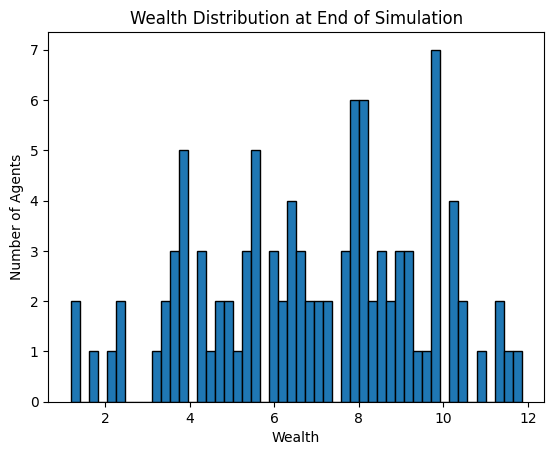

In [ ]:
wealths = [agent.money for agent in sim.agents]
plt.hist(wealths, bins=50, edgecolor='black')
plt.xlabel('Wealth')
plt.ylabel('Number of Agents')
plt.title('Wealth Distribution at End of Simulation')
plt.show()

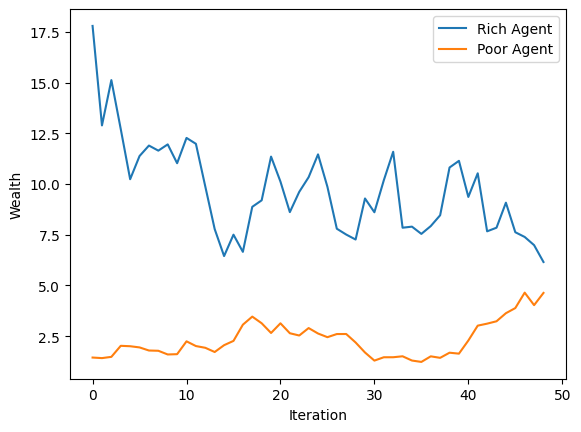

In [ ]:
# Plot the wealth of the tracked agents
plt.plot(sim.rich_agent_wealth, label='Rich Agent')
# plt.plot(sim.middle_agent_wealth, label='Middle Agent')
plt.plot(sim.poor_agent_wealth, label='Poor Agent')
plt.xlabel('Iteration')
plt.ylabel('Wealth')
plt.legend()
plt.show()

In [ ]:
np.mean(gini_indices)

0.22956932648005743

In [ ]:
gini_indices[-1]

0.20984473656421448